In [592]:
import pandas as pd
import re
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import nltk
import numpy as np
import string
import matplotlib.pyplot as plt

%matplotlib inline

In [682]:
df1 = pd.read_csv('../data/allerhande_1954_1973.csv')
df2 = pd.read_csv('../data/allerhande_1979_2001.csv')
lexicon = pd.read_csv('../data/lexicon.csv')
df1.drop('Unnamed: 0', axis=1, inplace=True)
df1['text_clean'] = df1['text_clean'].str.replace('koolzuurhoudend water', 'koolzuurhoudend_water', case=False)

#remove punctuation
df1['text_clean'] = df1['text_clean'].str.replace('[{}]'.format(string.punctuation), '')
#df1['text_clean'] = df1['text_clean'].str.replace('...', '')
df2['content'] = df2['content'].str.replace('[{}]'.format(string.punctuation), '')

In [683]:
science_terms = list(lexicon[lexicon['categorie 1'] == 'wetenschap']['woorden'].values)
pleasure_terms = list(lexicon[lexicon['categorie 1'] == 'genot']['woorden'].values)
search_terms = list(lexicon[lexicon['categorie 1'] == 'water']['woorden'].values)

In [684]:
search_terms.remove('koolzuurhoudend')
search_terms.remove('koolzuur')
search_terms.remove('mineraal')
search_terms.append('koolzuurhoudend_water')

In [685]:
df2.columns = ['avg_quality', 'text_clean', 'issue', 'page_nr', 'total_pages', 'year',
              'month', 'day', 'comment']

In [686]:
df_merge = df1.append(df2)

In [549]:
def find_fuzzy_search_terms(text, search_terms, ratio):
    fuzzy_terms = []
    tokens = text.lower().split()
    for search_term in search_terms:
        matches = process.extract(search_term, tokens, scorer=fuzz.ratio, limit=10)
        fuzzies = [match[0] for match in matches if match[1] > ratio]
        if fuzzies:
            fuzzy_terms.append(fuzzies)
    return fuzzy_terms

def extract_chunks(text, search_terms, context_size):
    chunk = []
    tokens = text.lower().split()
    indices = [i for i,word in enumerate(tokens) if word in search_terms]
    #remove overlapping chunks
    for i, ind in enumerate(indices):
        if i > 0:
            if indices[i] < (indices[i-1] + context_size):
                indices.remove(ind)     
        else:
            pass
    
    for ind in indices:
        if ind - context_size < 0:
            left_context = 0
        else:
            left_context = ind - context_size
        if (ind + 1) + context_size > len(tokens):
            right_context = len(tokens)
        else:
            right_context = (ind + 1) + context_size
        chunk.append(tokens[left_context:ind]+ tokens[ind:ind+1] + tokens[ind+1:right_context])
    if chunk:
        return chunk
    else:
        return np.nan

        



In [ ]:
# text = df_merge['text_clean'].to_string()
# fuzzy_matches = find_fuzzy_search_terms(text, search_terms, 90)

In [688]:
df_merge['water_text'] = df_merge['text_clean'].astype(str).apply(lambda x: extract_chunks(x, search_terms, 50))

In [690]:
df_merge = df_merge.dropna(subset=['water_text'])

In [691]:
df_merge.sort_values('year', inplace=True)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [692]:
x = df_merge.groupby('year')['water_text'].count().index
y = df_merge.groupby('year')['water_text'].count().values

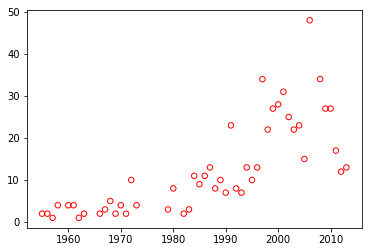

In [693]:
plt.scatter(x, y, s=30, facecolors='none', edgecolors='r')
plt.savefig('overview.png')

In [694]:
def count_science_terms(text, science_terms):
    counter = 0
    for term in science_terms:
        if term in text:
            counter +=1
    return counter

def count_pleasure_terms(text, pleasure_terms):
    counter = 0
    for term in pleasure_terms:
        if term in text:
            counter +=1
    return counter

In [697]:
df_merge['science'] = df_merge['text_clean'].astype(str).apply(lambda x: count_science_terms(x, 
                                                                                science_terms))
df_merge['pleasure'] = df_merge['text_clean'].astype(str).apply(lambda x: count_pleasure_terms(x,
                                                                                            pleasure_terms))
          

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [740]:
df2['science'] = df2['text_clean'].astype(str).apply(lambda x: count_science_terms(x, 
                                                                                science_terms))
df2['pleasure'] = df2['text_clean'].astype(str).apply(lambda x: count_pleasure_terms(x, 
                                                                                pleasure_terms))

In [741]:
df2.sort_values('year', inplace=True)

In [752]:
df2['length'] = df2['text_clean'].str.len()
articles_per_year = df2.groupby('year')['text_clean'].count().values
words_per_year = df2.groupby('year')['length'].mean().values


x = df2.groupby('year')['text_clean'].count().index
y_science = (df2.groupby('year')['science'].sum().values / words_per_year)
y_pleasure = (df2.groupby('year')['pleasure'].sum().values / words_per_year)

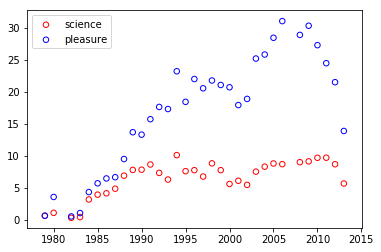

In [753]:
plt.scatter(x, y_science, s=30, facecolors='none', edgecolors='r', label='science')
plt.scatter(x, y_pleasure, s=30, facecolors='none', edgecolors='b', label='pleasure')
plt.savefig('overview_entire_set.png')
plt.legend()

In [737]:
df_merge['length'] = df_merge['text_clean'].str.len()
articles_per_year = df_merge.groupby('year')['text_clean'].count().values
words_per_year = df_merge.groupby('year')['length'].sum().values
x = df_merge.groupby('year')['text_clean'].count().index
y_science = (df_merge.groupby('year')['science'].sum().values)
y_pleasure = (df_merge.groupby('year')['pleasure'].sum().values)

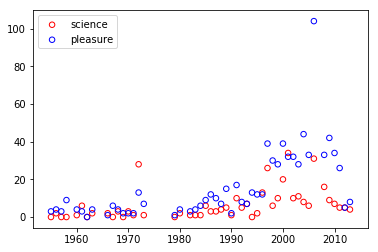

In [738]:
plt.scatter(x, y_science, s=30, facecolors='none', edgecolors='r', label='science')
plt.scatter(x, y_pleasure, s=30, facecolors='none', edgecolors='b', label='pleasure')
plt.savefig('overview_entire_set.png')
plt.legend()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [730]:
df_merge

,article,avg_quality,comment,day,filename,issue,month,page_nr,text_clean,total_pages,year,water_text,science,pleasure,length
469,16.0,NaN,NaN,NaN,1955-08_16.txt,NaN,08,NaN,H FOSCO kan koud of warm worden gedronken Aang...,NaN,1955.0,"[[h, fosco, kan, koud, of, warm, worden, gedro...",0,3,255
536,2.0,NaN,NaN,NaN,1955-09_2.txt,NaN,09,NaN,IJERINNERT w zich nog de vraag die mevrouw V t...,NaN,1955.0,"[[dank, voor, de, geboden, hulp, de, heer, a, ...",0,0,906
1061,7.0,NaN,NaN,NaN,1956-08_7.txt,NaN,08,NaN,Mogelijkheden Bg de bereiding van dran ken Enk...,NaN,1956.0,"[[mogelijkheden, bg, de, bereiding, van, dran,...",1,3,924
1325,8.0,NaN,NaN,NaN,1956-12_8.txt,NaN,12,NaN,VRUCHTENBOWL Benodigd 1 blikje aardbeien 1 bli...,NaN,1956.0,"[[gesneden, ananas, 3, in, schijfjes, gesneden...",1,1,392
1806,1.0,NaN,NaN,NaN,1957-07_1.txt,NaN,07,NaN,Afgezien van het feit dat een modeshow op zn t...,NaN,1957.0,"[[een, heel, klein, percentage, van, de, showb...",0,3,1296
2088,7.0,NaN,NaN,NaN,1958-01_7.txt,NaN,01,NaN,In werkelijkheid is de aardsatel Het studio B ...,NaN,1958.0,"[[zeepvlokkensneeuw, gevallen, dat, niemand, z...",0,2,2677
2457,2.0,NaN,NaN,NaN,1958-07_2.txt,NaN,07,NaN,De meest zomerse van alle dranken VRUCHTENBOWL...,NaN,1958.0,"[[persico, triplesec, of, iets, van, dien, aar...",0,5,1558
21315,5.0,NaN,NaN,NaN,1958-08_5.txt,NaN,08,NaN,Op de Hogendijk niet zichtbaar op de foto ligt...,NaN,1958.0,"[[ketelhuis, waarin, uit, een, oogpunt, van, h...",0,1,2170
21133,2.0,NaN,NaN,NaN,1958-04_2.txt,NaN,04,NaN,afvoer van de uitgeademde en verbruikte lucht ...,NaN,1958.0,"[[diepduiken, langzaam, gebeuren, een, duiker,...",0,1,2485
21746,1.0,NaN,NaN,NaN,1960-08_1.txt,NaN,08,NaN,voegt zij er ter verduidelijking aan toe „Je ...,NaN,1960.0,"[[veel, van, bloemen, is, het, niet, zei, ik, ...",0,2,640
